# Atividade de implementação e teste do Perceptron - Questão 2

**Nome:** Dimitri Leandro de Oliveira Silva

**RA:** 11201720576

## Enunciado:

2) Testar o algoritmo implementado no conjunto de dados “Olivetti Faces”. Comparar com os resultados obtidos com om KNN.

## Sobre as Implementações

Os detalhes sobre as implementações estão no jupyter referente à Questão 1.

## Importando os pacotes necessários

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
from wand.image import Image
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split as tts
from sklearn.datasets import fetch_olivetti_faces

sys.path.append("/home/dimi/Programming/MachineLearningUFABC/Projeto_Perceptron_Adaline/Perceptron/python/")
from MultiNeuronClass import MultiNeuron

## Definindo algumas funções

In [2]:
def plotarResultadoTreinamento(arrayValoresTaxaAprendizagem, arrayObjMultiNeuron):
    colunas = ["Taxa de Aprendizagem", "Neurônio", "Total de Épocas", "Acurácia de Treinamento", "Critério de Parada"]
    data    = []

    for i, taxaAtual in enumerate(arrayValoresTaxaAprendizagem):    
        for j, neuronioAtual in enumerate(arrayObjMultiNeuron[i].arrayNeuronios):
            linha = [taxaAtual, j+1, neuronioAtual.qtdIteracoes, max(neuronioAtual.evolucaoAcuracias), neuronioAtual.motivoParada]
            data.append(linha)

    return pd.DataFrame(data=data, columns=colunas).style.hide_index()

In [3]:
def plotarACCxTaxa(arrayValoresTaxaAprendizagem, matrizAcuracias, matrizTemposTreinamento, matrizTemposTeste):
    %matplotlib inline
    %config InlineBackend.figure_format = 'svg'
    params = {'figure.figsize': [10, 5], 
              'figure.titlesize': 16,
              'axes.labelsize': 12,
              'axes.titlesize':14, 
              'font.size': 12,
              'legend.fontsize': 12, 
              'xtick.labelsize': 10, 
              'ytick.labelsize': 10
             }
    plt.rcParams.update(params)

    mediasAcuraciasCadaTaxa           = [np.mean(acuraciasTaxaAtual) for acuraciasTaxaAtual in matrizAcuracias]
    desvPadsAcuraciasCadaTaxa         = [np.std(acuraciasTaxaAtual) for acuraciasTaxaAtual in matrizAcuracias]
    mediasTemposTreinamentoCadaTaxa   = [np.mean(temposTreinamentoTaxaAtual) for temposTreinamentoTaxaAtual in matrizTemposTreinamento]
    mediasTemposTesteCadaTaxa         = [np.mean(temposTesteTaxaAtual) for temposTesteTaxaAtual in matrizTemposTeste]
    desvPadsTemposTreinamentoCadaTaxa = [np.std(temposTreinamentoTaxaAtual) for temposTreinamentoTaxaAtual in matrizTemposTreinamento]
    desvPadsTemposTesteCadaTaxa       = [np.std(temposTesteTaxaAtual) for temposTesteTaxaAtual in matrizTemposTeste]
    
    # PLOTANDO
    fig, ax1 = plt.subplots()

    ax1.errorbar(arrayValoresTaxaAprendizagem, mediasAcuraciasCadaTaxa, yerr=desvPadsAcuraciasCadaTaxa, capsize=3, fmt=".--", color="tab:blue", label="Acurácia de Teste")
    ax1.set_xlabel("Taxa de Aprendizagem")
    ax1.set_ylabel("Acurácia")

    ax2 = ax1.twinx()

    ax2.errorbar(arrayValoresTaxaAprendizagem, mediasTemposTreinamentoCadaTaxa, yerr=desvPadsTemposTreinamentoCadaTaxa, capsize=3, fmt=".--", color="tab:green", label="Tempo de Treinamento")
    ax2.errorbar(arrayValoresTaxaAprendizagem, mediasTemposTesteCadaTaxa, yerr=desvPadsTemposTesteCadaTaxa, capsize=3, fmt=".--", color="tab:orange", label="Tempo de Teste")
    ax2.set_ylabel("Tempo (s)")

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc="center right")
    plt.xscale("log")
    plt.title("Olivetti Faces - Perceptron Implementado")
    plt.grid(alpha=0.5)
    plt.show()

## Importando os dataset Olivetti Faces

In [4]:
datasetOlivetti = fetch_olivetti_faces()
data            = datasetOlivetti.data
target          = datasetOlivetti.target

# AS LINHAS ABAIXO SERVEM PARA LIMITAR O TAMANHO DO DATASET 
# USAR APENAS PARA REALIZAR TESTES RAPIDOS
#data   = data[0:50] # REDUZINDO PARA APENAS 5 CLASSES (TESTES RÁPIDOS)
#target = target[0:50] # REDUZINDO PARA APENAS 5 CLASSES (TESTES RÁPIDOS)

In [5]:
%%time

# MATRIZES -> CADA LINHA E UM VALOR DE TAXA DE APRENDIZAGEM E CADA COLUNA E UMA INTERACAO DO HOLDOUT
matrizAcuracias         = []
matrizTemposTreinamento = []
matrizTemposTeste       = []

# DEFININDO O RANGE DA TAXA DE APRENDIZAGEM
arrayValoresTaxaAprendizagem = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0, 1e+1, 1e+2, 1e+3]

# PARA CADA VALOR DE TAXA
for taxaAtual in arrayValoresTaxaAprendizagem:
    
    print("Iniciando os testes com taxa de " + str(taxaAtual) + ":")
    
    linhaAcuraciasTaxaAtual         = []
    linhaTemposTreinamentoTaxaAtual = []
    linhaTemposTesteTaxaAtual       = []
    
    # FACO UM BOOTSTRAP COM H HOLDOUTS
    H = 5
    for h in range(H):
        
        # SEPARANDO ENTRE DADOS DE TREINAMENTO E TESTE
        xTrain, xTest, yTrain, yTest = tts(data, target, test_size=0.25, shuffle=True)
        
        # UTILIZANDO A CLASSE CRIADA PARA TREINAR E TESTAR
        objMultiNeuron = MultiNeuron(taxaAprendizagem=taxaAtual, percentualSemMelhora=0.35)
        inicioTreinamento = time.time()
        objMultiNeuron.treinar(xTrain, yTrain)
        fimTreinamento = time.time()
        inicioTeste = time.time()
        yPred = objMultiNeuron.predizer(xTest)
        fimTeste = time.time()
        
        # COLOCANDO O RESULTADO NA LINHA DA TAXA ATUAL NA MATRIZ DE ACURACIAS
        linhaAcuraciasTaxaAtual.append(accuracy_score(yTest, yPred))
        linhaTemposTreinamentoTaxaAtual.append(fimTreinamento - inicioTreinamento)
        linhaTemposTesteTaxaAtual.append(fimTeste - inicioTeste)
        
        print(str(100*(h+1)/H) + "% concluido.")
        
    # AGORA QUE JA TENHO TODOS OS RESULTADOS DO HOLDOUT PARA A TAXA ATUAL, COLOCO A NOVA LINHA NA MATRIZ
    matrizAcuracias.append(linhaAcuraciasTaxaAtual)
    matrizTemposTreinamento.append(linhaTemposTreinamentoTaxaAtual)
    matrizTemposTeste.append(linhaTemposTesteTaxaAtual)

Iniciando os testes com taxa de 1e-05:
20.0% concluido.
40.0% concluido.
60.0% concluido.
80.0% concluido.
100.0% concluido.
Iniciando os testes com taxa de 0.0001:
20.0% concluido.
40.0% concluido.
60.0% concluido.
80.0% concluido.
100.0% concluido.
Iniciando os testes com taxa de 0.001:
20.0% concluido.
40.0% concluido.
60.0% concluido.
80.0% concluido.
100.0% concluido.
Iniciando os testes com taxa de 0.01:
20.0% concluido.
40.0% concluido.
60.0% concluido.
80.0% concluido.
100.0% concluido.
Iniciando os testes com taxa de 0.1:
20.0% concluido.
40.0% concluido.
60.0% concluido.
80.0% concluido.
100.0% concluido.
Iniciando os testes com taxa de 1.0:
20.0% concluido.
40.0% concluido.
60.0% concluido.
80.0% concluido.
100.0% concluido.
Iniciando os testes com taxa de 10.0:
20.0% concluido.
40.0% concluido.
60.0% concluido.
80.0% concluido.
100.0% concluido.
Iniciando os testes com taxa de 100.0:
20.0% concluido.
40.0% concluido.
60.0% concluido.
80.0% concluido.
100.0% concluido.
Inici

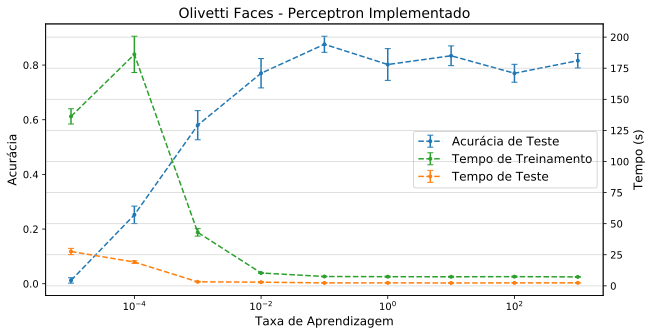

In [6]:
plotarACCxTaxa(arrayValoresTaxaAprendizagem, matrizAcuracias, matrizTemposTreinamento, matrizTemposTeste)

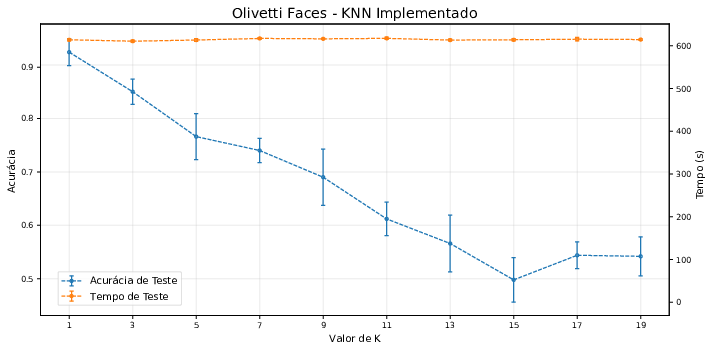

In [7]:
Image(filename="/home/dimi/Programming/MachineLearningUFABC/Projeto_KNN/resultados/imagens/resultado_OlivettiFaces_KNN_Implementado.pdf")